<a href="https://colab.research.google.com/github/juampismon/IAHR24_LISBON/blob/main/04_Pexcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set the environment

### Import and install required libraries

In [ ]:
!pip install pyogrio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 32.8 MB/s eta 0:00:00


In [ ]:
# Import the libraries already installed in the Colab virtual machine.
import os
from os.path import join as opj
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from pyproj import Proj
# Install the libraries NOT installed in the Colab virtual machine.
!pip install rioxarray
# Import the recently installed libraries
import rioxarray



pd.options.mode.copy_on_write = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 53.9 MB/s eta 0:00:00


### Create a connection to your Drive

In [ ]:
from google.colab import drive
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install the hda module and set up the HDA Client

In [1]:
# Install the latest version of hda
!pip install hda -U

  Preparing metadata (setup.py) ... done
  Created wheel for hda: filename=hda-2.14-py3-none-any.whl size=15156 sha256=1b2f93f4a9dc1101b5cca1cdb30c83cb38ff523003e259b52efdb9758a80df14
  Stored in directory: /root/.cache/pip/wheels/f0/b9/9c/ebfae7fbd338f77aa889fa40cc39d21b0eb5360d564356b08e
Successfully built hda


In [ ]:
# Import the needed functions from the hda module
from hda import Client, Configuration

# Configure credentials and load hda Client
### Create the .hdarc configuration file as follows:
from pathlib import Path

# Default location expected by hda package
hdarc = Path(Path.home() / '.hdarc')

# Create or re-write the .hdarc file
import getpass
USERNAME = input('Enter your username: ')
PASSWORD = getpass.getpass('Enter your password: ')

with open(Path.home() / '.hdarc', 'w') as f:
  f.write(f'user:{USERNAME}\n')
  f.write(f'password:{PASSWORD}\n')

### Load the hda client using the default .hdarc file for getting your credentials
hda_client = Client()

Enter your username: garciamonjp
Enter your password: ··········


## Download data

### Download the precipitation at a fixed return period

The annual maximum daily precipitation at a return period of 5, 25 or 100 from the [Extreme precipitation risk indicators for Europe and European cities from 1950 to 2019 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-european-risk-extreme-precipitation-indicators?tab=overview).

In [ ]:

query  ={
  "datasetId": "EO:ECMWF:DAT:SIS_EUROPEAN_RISK_EXTREME_PRECIPITATION_INDICATORS",
  "stringChoiceValues": [
    {
      "name": "format",
      "value": "zip"
    }
  ],
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "precipitation_at_fixed_return_periods"
      ]
    },
    {
      "name": "spatial_coverage",
      "value": [
        "europe"
      ]
    },
    {
      "name": "temporal_aggregation",
      "value": [
        "30_year"
      ]
    },
    {
      "name": "return_period",
      "value": ["5-yrs",
        "25-yrs", "100-yrs"
      ]
    },
    {
      "name": "period",
      "value": [
        "1989-2018"
      ]
    },
    {
      "name": "product_type",
      "value": [
        "era5",
        "e_obs",
        "eca_d"
      ]
    }
  ]
}
# Configure the client not to show download progress
hda_client_NP = Client(progress=False)
# Ask and check the results for the query
matches = hda_client_NP.search(query)
print(matches)
matches.download(download_dir="./temp/EU_FLOOD_RISK")

SearchResults[items=1,volume=ND]


In [ ]:
!unzip /content/temp/EU_FLOOD_RISK/157b9bc27c3e514e1d6db7832726dda0.zip

Archive:  /content/temp/EU_FLOOD_RISK/157b9bc27c3e514e1d6db7832726dda0.zip
  inflating: precipitation-at-fixed-return-period_europe_ecad_30-year_25-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_ecad_30-year_100-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_era5_30-year_100-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_ecad_30-year_5-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_e-obs_30-year_25-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_era5_30-year_5-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_era5_30-year_25-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_e-obs_30-year_5-yrs_1989-2018_v1.nc  
  inflating: precipitation-at-fixed-return-period_europe_e-obs_30-year_100-yrs_1989-2018_v1.nc  


In [ ]:
# Open the NetCDF file with the precipitation information using xarray.
E_obs_100yr = xr.open_dataset('/content/precipitation-at-fixed-return-period_europe_e-obs_30-year_100-yrs_1989-2018_v1.nc',
                        decode_coords = "all")
# Assign the SRC as: <<EPSG:4326>>
E_obs_100yr = E_obs_100yr.rio.write_crs("EPSG:4326")
# We can see that the crs is correctly assigned
E_obs_100yr.rio.crs

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/precipitation-at-fixed-return-period_europe_e-obs_30-year_100-yrs_1989-2018_v1.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# We take a look at the xarray dataset we have generated
E_obs_100yr

<xarray.Dataset>
Dimensions:      (latitude: 360, longitude: 650)
Coordinates:
  * latitude     (latitude) float64 35.05 35.15 35.25 ... 70.75 70.85 70.95
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 39.75 39.85 39.95
    spatial_ref  int64 0
Data variables:
    r100yrrp     (latitude, longitude) float64 ...
Attributes:
    source:       EOBS
    Conventions:  CF-1.6
    contacts:     copernicus-support@ecmwf.int
    contract:     C3S_430 Sectoral Information System to support Disaster Ris...
    title:        Extreme precipitation indicators for Europe and European ci...
    institution:  Fondazione Centro Euro-Mediterraneo sui Cambiamenti Climati...
    author:       Fondazione Centro Euro-Mediterraneo sui Cambiamenti Climati...
    version:      version 1.0

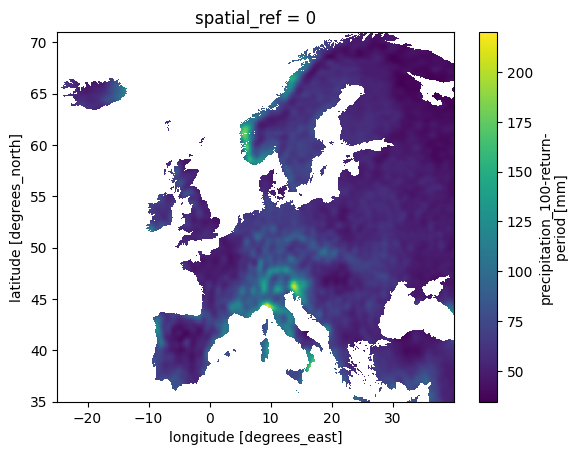

In [ ]:
# Plot to visualise (any day of the series)
E_obs_100yr_plt = E_obs_100yr.r100yrrp
E_obs_100yr_plt.attrs = E_obs_100yr.r100yrrp.attrs
E_obs_100yr_plt = E_obs_100yr_plt.isel()
E_obs_100yr_plt.attrs["units"] = "mm"
E_obs_100yr_plt.plot();

In [ ]:
# Open the NetCDF file with the precipitation information using xarray.
ECAD_100yr = xr.open_dataset('/content/precipitation-at-fixed-return-period_europe_ecad_30-year_100-yrs_1989-2018_v1.nc',
                        decode_coords = "all")
# Assign the SRC as: <<EPSG:4326>>
ECAD_100yr = ECAD_100yr.rio.write_crs("EPSG:4326")
# We can see that the crs is correctly assigned
ECAD_100yr

<xarray.Dataset>
Dimensions:      (latitude: 360, longitude: 650)
Coordinates:
  * latitude     (latitude) float64 70.95 70.85 70.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 39.75 39.85 39.95
    spatial_ref  int64 0
Data variables:
    r100yrrp     (latitude, longitude) float32 ...
Attributes:
    source:       ECAD
    Conventions:  CF-1.6
    contacts:     copernicus-support@ecmwf.int
    contract:     C3S_430 Sectoral Information System to support Disaster Ris...
    title:        Extreme precipitation indicators for Europe and European ci...
    institution:  Fondazione Centro Euro-Mediterraneo sui Cambiamenti Climati...
    author:       Fondazione Centro Euro-Mediterraneo sui Cambiamenti Climati...
    version:      version 1.0

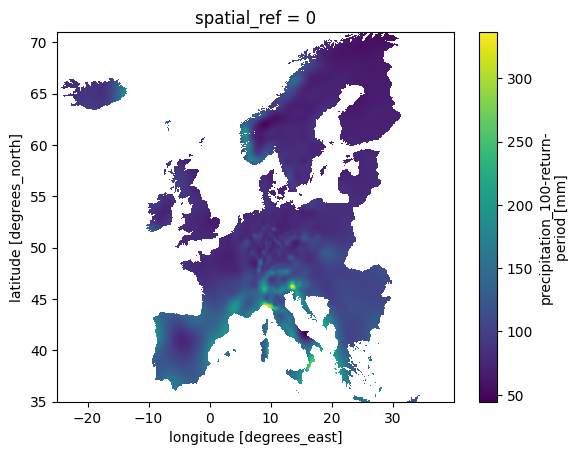

In [ ]:
# Plot to visualise (any day of the series)
ECAD_100yr_plt = ECAD_100yr.r100yrrp
ECAD_100yr_plt.attrs = ECAD_100yr.r100yrrp.attrs
ECAD_100yr_plt = ECAD_100yr_plt.isel()
ECAD_100yr_plt.attrs["units"] = "mm"
ECAD_100yr_plt.plot();

In [ ]:
# Open the NetCDF file with the precipitation information using xarray.
ERA_100yr = xr.open_dataset('/content/precipitation-at-fixed-return-period_europe_era5_30-year_100-yrs_1989-2018_v1.nc',
                        decode_coords = "all")
# Assign the SRC as: <<EPSG:4326>>
ERA_100yr = ERA_100yr.rio.write_crs("EPSG:4326")
# We can see that the crs is correctly assigned
ERA_100yr

<xarray.Dataset>
Dimensions:      (latitude: 145, longitude: 261)
Coordinates:
  * latitude     (latitude) float64 71.0 70.75 70.5 70.25 ... 35.5 35.25 35.0
  * longitude    (longitude) float64 -25.0 -24.75 -24.5 ... 39.5 39.75 40.0
    spatial_ref  int64 0
Data variables:
    r100yrrp     (latitude, longitude) float64 ...
Attributes:
    source:       ERA5
    Conventions:  CF-1.6
    contacts:     copernicus-support@ecmwf.int
    contract:     C3S_430 Sectoral Information System to support Disaster Ris...
    title:        Extreme precipitation indicators for Europe and European ci...
    institution:  Fondazione Centro Euro-Mediterraneo sui Cambiamenti Climati...
    author:       Fondazione Centro Euro-Mediterraneo sui Cambiamenti Climati...
    version:      version 1.0

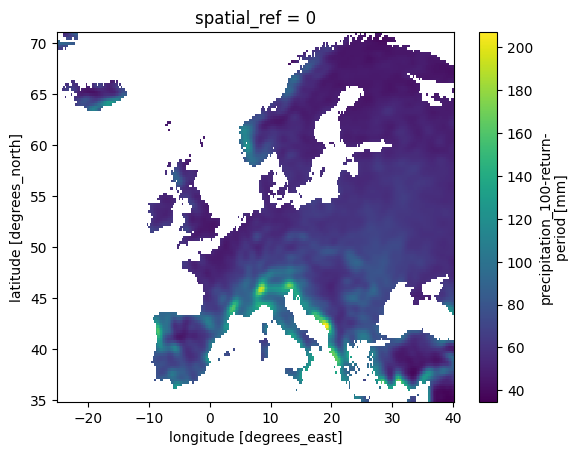

In [ ]:
# Plot to visualise (any day of the series)
ERA_100yr_plt = ERA_100yr.r100yrrp
ERA_100yr_plt.attrs = ERA_100yr.r100yrrp.attrs
ERA_100yr_plt = ERA_100yr_plt.isel()
ERA_100yr_plt.attrs["units"] = "mm"
ERA_100yr_plt.plot();

### Download the selected basins data

In [ ]:
# Path to the file
IP_basins_path = '/content/drive/MyDrive/Iberia_project/IP_Selected_basins.gpkg'

IP_basins_gdf = gpd.read_file(IP_basins_path, engine= 'pyogrio', use_arrow=True) ## < 20 s
# Show the GeoDataFrame tabular data
IP_basins_gdf

index    Basin_ID            CN_2012            CN_2018  \
0     Duer100003  Duer100003  65.33163874232591  63.22603090082514   
1     Duer100050  Duer100050   83.2349844220272  83.31494086223201   
2     Duer100194  Duer100194   69.9535354655373  69.26451288573352   
3     Duer100207  Duer100207  65.95558743149225   66.7592413477809   
4     Duer100231  Duer100231  65.91190670836976  67.13092902772453   
...          ...         ...                ...                ...   
1138  Tajo107523  Tajo107523  71.78749368285771  73.36820053739555   
1139  Tajo107567  Tajo107567  79.16939357564637  73.23156522861566   
1140  Tajo107574  Tajo107574  56.20619941024804  58.85997711137982   
1141  Tajo107580  Tajo107580                 89                 89   
1142  Tajo107702  Tajo107702  63.82860405148906  64.45552720897525   

                CN_change                                           geometry  
0      -2.105607841500763  MULTIPOLYGON (((3032153.334 2053840.916, 30321...  
1     0.07995644020481052  MULTIPOLYGON (((2765050.000 2198325.000, 27649...  
2     -0.6890225798037761  MULTIPOLYGON (((2779425.000 2364675.000, 27794...  
3      0.8036539162886527  MULTIPOLYGON (((2794300.000 2366775.000, 27941...  
4       1.219022319354778  MULTIPOLYGON (((3136440.595 2371987.346, 31364...  
...                   ...                                                ...  
1138    1.580706854537837  MULTIPOLYGON (((2676375.000 2025650.000, 26763...  
1139   -5.937828347030703  MULTIPOLYGON (((3008684.281 2037836.251, 30085...  
1140     2.65377770113178  MULTIPOLYGON (((2905900.000 2062944.326, 29059...  
1141                    0  MULTIPOLYGON (((2864897.709 2104675.000, 28649...  
1142   0.6269231574861962  MULTIPOLYGON (((2850575.000 2122300.000, 28505...  

[1143 rows x 6 columns]

### Download all Iberian Peninsula basins

In [ ]:
# Path to the file
IP_allbasins_path = '/content/drive/MyDrive/Iberia_project/03_Results/Iberia_Basins.gpkg'

IP_allbasins_gdf = gpd.read_file(IP_allbasins_path, engine= 'pyogrio', use_arrow=True) ## < 20 s
# Show the GeoDataFrame tabular data
IP_allbasins_gdf

h1_id namebasin       h3_id h4_id h5_id h6_id       h2_id h7_id  \
0      EU1H100202     Duero        None  None  None  None  EU1H201753  None   
1      EU1H100202     Duero  EU1H304850  None  None  None  EU1H201753  None   
2      EU1H100202     Duero  EU1H304823  None  None  None  EU1H201753  None   
3      EU1H100202     Duero  EU1H304711  None  None  None  EU1H201753  None   
4      EU1H100202     Duero  EU1H304711  None  None  None  EU1H201753  None   
...           ...       ...         ...   ...   ...   ...         ...   ...   
27182  EU1H100348      Tajo  EU1H304705  None  None  None  EU1H202764  None   
27183  EU1H100348      Tajo  EU1H305816  None  None  None  EU1H202422  None   
27184  EU1H100566      Tajo        None  None  None  None        None  None   
27185  EU1H100566      Tajo        None  None  None  None        None  None   
27186  EU1H100566      Tajo        None  None  None  None        None  None   

      PFAFSTETER   Basin_ID  Basins_Area_km2  \
0           None  Due100000         0.101305   
1           None  Due100001         0.107661   
2           None  Due100002         0.100574   
3           None  Due100003         0.229556   
4           None  Due100004         0.191780   
...          ...        ...              ...   
27182       None  Taj107718       114.325069   
27183       None  Taj107719        48.230485   
27184       None  Taj107720        10.489152   
27185       None  Taj107721       541.152549   
27186       None  Taj107722       125.697400   

                                                geometry  
0      MULTIPOLYGON (((3041514.215 2046385.631, 30415...  
1      MULTIPOLYGON (((3039417.333 2050713.770, 30392...  
2      MULTIPOLYGON (((3034229.386 2051841.755, 30341...  
3      MULTIPOLYGON (((3032153.334 2053840.916, 30321...  
4      MULTIPOLYGON (((3032333.043 2056051.897, 30323...  
...                                                  ...  
27182  MULTIPOLYGON (((3126925.000 2059200.000, 31268...  
27183  MULTIPOLYGON (((3187500.000 2003800.000, 31873...  
27184  MULTIPOLYGON (((2777857.484 1746905.528, 27778...  
27185  MULTIPOLYGON (((2777816.561 1746929.801, 27778...  
27186  MULTIPOLYGON (((2829975.000 1912700.000, 28299...  

[27187 rows x 12 columns]

In [ ]:
!pip install contextily

In [ ]:
import contextily as cx

In [ ]:
!pip install cartopy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.9 MB/s eta 0:00:00


In [ ]:
import seaborn as sns

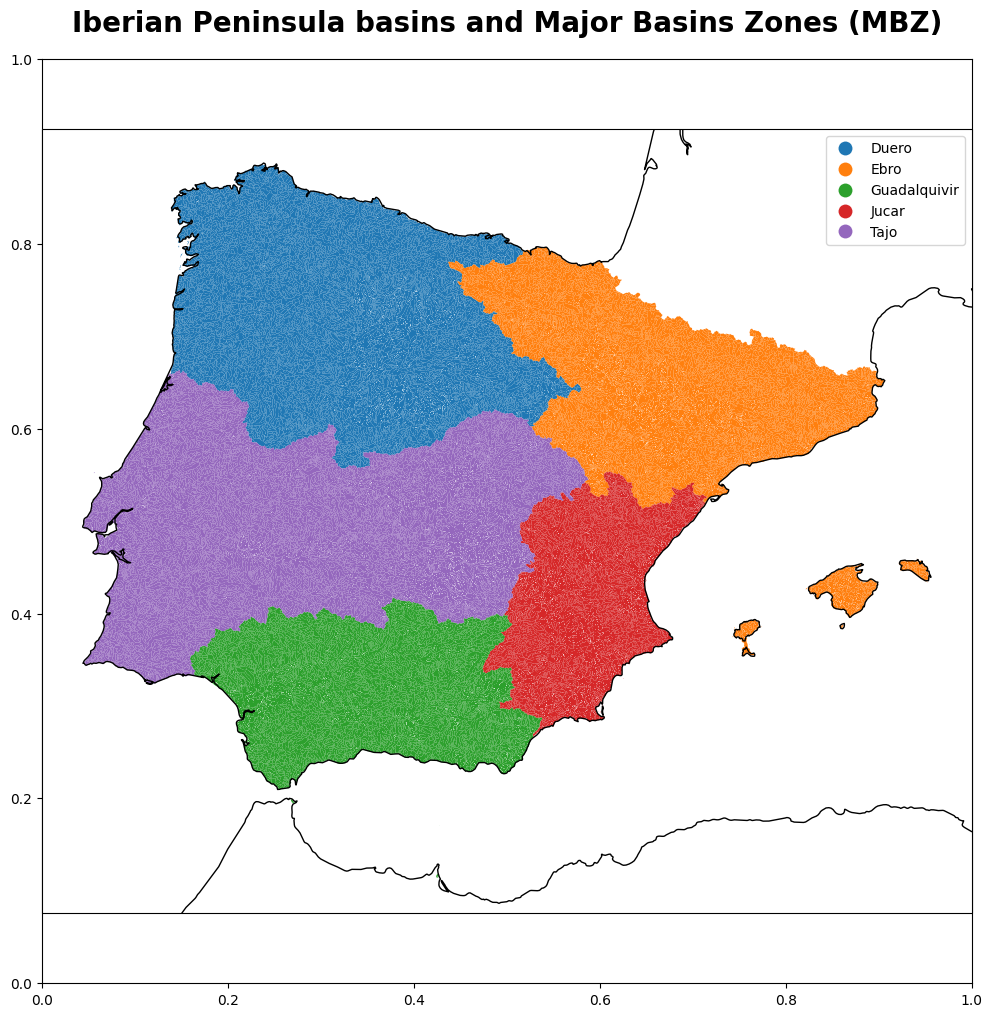

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.colors as mcolors

# Load the coastline data directly from Cartopy
coastlines = cfeature.COASTLINE.with_scale('10m')

# Plot using matplotlib and GeoPandas
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Iberian Peninsula basins and Major Basins Zones (MBZ)', pad=20, fontsize=20, fontweight='semibold')

# Add the coastal border lines as a background map using Cartopy
ax = plt.axes(projection=ccrs.epsg(3035))
ax.add_feature(coastlines, linewidth=1)

# Reproject GeoPandas data to match CRS 3035
IP_allbasins_gdf = IP_allbasins_gdf.to_crs(epsg=3035)

# Get the "tab10" color palette from Seaborn
tab10_palette = sns.color_palette("tab10")

# Select the first five colors from the palette
first_five_colors = tab10_palette[:5]

# Create a colormap using the selected colors
cmap = mcolors.ListedColormap(first_five_colors)

# Plot GeoPandas data with the created colormap
IP_allbasins_gdf.plot(ax=ax, column="namebasin", legend=True, legend_kwds={"loc": "upper right"}, cmap=cmap)

plt.show()



### Take a quick look at the change in the curve number for each Major basin zone.

In [ ]:
# Define a dictionary mapping basin prefixes to zone names
zone_mapping = {
    'Juca': 'Jucar',
    'Guad': 'Guadalquivir',
    'Ebro': 'Ebro',
    'Duer': 'Duero',
    'Tajo': 'Tajo'
}

# Extract the first four letters from 'Basin_ID' and map them to zone names
IP_basins_gdf['MBZ_name'] = IP_basins_gdf['Basin_ID'].str[:4].map(zone_mapping)

# Display the DataFrame with the added 'MBZ_name' column
IP_basins_gdf

index    Basin_ID            CN_2012            CN_2018  \
0     Duer100003  Duer100003  65.33163874232591  63.22603090082514   
1     Duer100050  Duer100050   83.2349844220272  83.31494086223201   
2     Duer100194  Duer100194   69.9535354655373  69.26451288573352   
3     Duer100207  Duer100207  65.95558743149225   66.7592413477809   
4     Duer100231  Duer100231  65.91190670836976  67.13092902772453   
...          ...         ...                ...                ...   
1138  Tajo107523  Tajo107523  71.78749368285771  73.36820053739555   
1139  Tajo107567  Tajo107567  79.16939357564637  73.23156522861566   
1140  Tajo107574  Tajo107574  56.20619941024804  58.85997711137982   
1141  Tajo107580  Tajo107580                 89                 89   
1142  Tajo107702  Tajo107702  63.82860405148906  64.45552720897525   

                CN_change                                           geometry  \
0      -2.105607841500763  MULTIPOLYGON (((3032153.334 2053840.916, 30321...   
1     0.07995644020481052  MULTIPOLYGON (((2765050.000 2198325.000, 27649...   
2     -0.6890225798037761  MULTIPOLYGON (((2779425.000 2364675.000, 27794...   
3      0.8036539162886527  MULTIPOLYGON (((2794300.000 2366775.000, 27941...   
4       1.219022319354778  MULTIPOLYGON (((3136440.595 2371987.346, 31364...   
...                   ...                                                ...   
1138    1.580706854537837  MULTIPOLYGON (((2676375.000 2025650.000, 26763...   
1139   -5.937828347030703  MULTIPOLYGON (((3008684.281 2037836.251, 30085...   
1140     2.65377770113178  MULTIPOLYGON (((2905900.000 2062944.326, 29059...   
1141                    0  MULTIPOLYGON (((2864897.709 2104675.000, 28649...   
1142   0.6269231574861962  MULTIPOLYGON (((2850575.000 2122300.000, 28505...   

     MBZ_name  
0       Duero  
1       Duero  
2       Duero  
3       Duero  
4       Duero  
...       ...  
1138     Tajo  
1139     Tajo  
1140     Tajo  
1141     Tajo  
1142     Tajo  

[1143 rows x 7 columns]

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Create a new dataframe with just 'CN_2018' and 'CN_2012' values
overall_df = pd.DataFrame({
    'CN_2018': IP_basins_gdf['CN_2018'],
    'CN_2012': IP_basins_gdf['CN_2012'],
    'MBZ_name': 'Iberian Peninsula'  # Fill the MBZ_name column with 'Iberian Peninsula'
})

# Create a new dataframe with just 'CN_2018' and 'CN_2012' values
overall_df2 = pd.DataFrame({
    'CN_2018': IP_basins_gdf['CN_2018'],
    'CN_2012': IP_basins_gdf['CN_2012'],
    'MBZ_name': IP_basins_gdf['MBZ_name'],  # Fill the MBZ_name column with 'Iberian Peninsula'
})

# Concatenate individual and overall dataframes
combined_df = pd.concat([overall_df, overall_df2])

# Create subplots with different axes
fig = go.Figure()

# Add an extra violin plot for the whole dataframe
fig.add_trace(go.Violin(x=combined_df['MBZ_name'], y=combined_df['CN_2018'], legendgroup='CN_2018', scalegroup='CN_2018', name='2018',
                         side='positive', line_color='rgba(50, 50, 50, 1)', points=False, box_visible=True, fillcolor=None))
fig.add_trace(go.Violin(x=combined_df['MBZ_name'], y=combined_df['CN_2012'], legendgroup='CN_2012', scalegroup='CN_2012', name='2012',
                         side='negative', line_color='rgba(140, 140, 140, 1)', points=False, box_visible=True, fillcolor=None))

# Update the layout to enhance the aesthetics
fig.update_layout(title="Limits for CN variation in a basin due to each discrete LULC change area",
                  xaxis_title='Analysis region', yaxis_title='Curve number (CN) [adimensional]',
                  height=800, margin=dict(l=50, r=50, t=50, b=50),
                  template="plotly_white",  # Use the 'plotly_white' template for a professional background
                  font=dict(family="Arial, sans-serif", size=24))  # Use 'Arial' font family


# Show plot
fig.show()



# Finally, add some water to the analysis

### Define functions

In [ ]:
!pip install bottleneck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
def open_EUdataset(src, rp_yr):
  dataset_path = '/content/precipitation-at-fixed-return-period_europe_'+ src +'_30-year_' + rp_yr +'-yrs_1989-2018_v1.nc'
  # Open the NetCDF file with the precipitation information using xarray.
  dataset = xr.open_dataset(
      dataset_path,
      decode_coords = "all"
      )
  # Assign the SRC as: <<EPSG:4326>>
  dataset  = dataset .rio.write_crs("EPSG:4326")
  # We can see that the crs is correctly assigned
  return dataset

In [ ]:
def clip_dataset(basin_gdf, europe_ds, H_resolution):
  basin_4326 = basin_gdf.to_crs(epsg=4326)
  # The minimum and maximum coordinates of the basin are extracted.
  basin_coords= basin_4326.total_bounds
  # Clip the ERA dataset around the basin extent
  basin_ds = europe_ds.rio.clip_box(
      minx=basin_coords[0]-H_resolution,
      miny=basin_coords[1]-H_resolution,
      maxx=basin_coords[2]+H_resolution,
      maxy=basin_coords[3]+H_resolution,
      crs="EPSG:4326",
  )

  # Fill NaN values with nearest non-NaN value along latitude dimension
  basin_ds = basin_ds.bfill(dim='latitude', limit= 2)
  basin_ds = basin_ds.bfill(dim='longitude', limit= 2)
  basin_ds = basin_ds.ffill(dim='latitude', limit= 2)
  basin_ds = basin_ds.ffill(dim='longitude', limit= 2)
  return basin_ds

In [ ]:
from pyproj import Proj
from shapely.geometry import Point
def xarray2gdf(basin_gdf, basin_ds, rp_yr):
    # Convert xarray.Dataset to pandas DataFrame
    df = basin_ds.to_dataframe().reset_index()

    # Create a geometry column using latitude and longitude
    df["geometry"] = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]

    df = df.drop('spatial_ref', axis=1)
    p = Proj(basin_gdf.crs, preserve_units=False)
    lon, lat = p(basin_gdf.centroid.x.iloc[0], basin_gdf.centroid.y.iloc[0], inverse=True) # inverse transform

    centroid_ds = basin_ds.interp(longitude=lon, latitude=lat, method='linear')

    data_var_name = 'r'+ rp_yr + 'yrrp'

    # Define the data
    data = {
        'latitude': centroid_ds['latitude'].values,
        'longitude': centroid_ds['longitude'].values,
        data_var_name: centroid_ds[data_var_name].values,
    }

    # Convert to pandas DataFrame
    df_centroid = pd.DataFrame(data, index=[0])

    # Create a geometry column using latitude and longitude
    df_centroid["geometry"] = [Point(lon, lat) for lon, lat in zip(df_centroid['longitude'], df_centroid['latitude'])]

    df = pd.concat([df, df_centroid], ignore_index=True)  # Use pd.concat to concatenate DataFrames

    # Convert pandas DataFrame to GeoPandas GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=4326)

    gdf = gdf.to_crs(basin_gdf.crs)

    return gdf


In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

def Extact4basin(basin_data, rp_yr):
  data_var_name = 'r'+ rp_yr + 'yrrp'
  # Get the x, y co-ordinates of the data points
  x_coords = basin_data["geometry"].x
  y_coords = basin_data["geometry"].y
  coords_points = [list(xy) for xy in zip(x_coords, y_coords)]

  # We add points at the ends to extend the calculation domain of the Voronoi diagram.
  basin_buffer = basin.buffer(100000)
  min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = basin_buffer.total_bounds
  coords_tp = coords_points + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                  [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

  # The Voronoi diagram is calculated for the points defined above.
  ThiessenPoly = Voronoi(coords_tp)

  # Closed regions are extracted from the Voronoi diagram.
  tp_poly_list = []
  for region in ThiessenPoly.regions:

      # Regions with -1 marker are ignored as it means they are not "closed".
      if -1 in region:
          continue
      else:
          pass

      # The markers are extracted to extract the vertices corresponding to each region in the "vertices" attribute.
      if len(region) != 0:
          tp_poly_region = Polygon(list(ThiessenPoly.vertices[region]))
          tp_poly_list.append(tp_poly_region)
      else:
          continue
  # A geopandas dataframe is created from the extracted information.
  tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = 'EPSG:3035')

  # Join data from basin data points to the Thiessen Polygons dataframe

  tp_data = tp_polys.sjoin(basin_data, how='left', predicate="contains")

  # Clip to the basin shape
  tp_polys_clipped = tp_data.clip(basin)
  tp_polys_clipped['Area_Ha'] = tp_polys_clipped.area

  # Estimate the ponderated value for the basin
  w_value = (tp_polys_clipped['Area_Ha'] * tp_polys_clipped[data_var_name]).sum() / tp_polys_clipped['Area_Ha'].sum()

  return w_value


### Estimate the average maximum daily rainfall in a return period of 5, 25 and 100 years for each basin and each data source (i.e. ERA5, ECA&D and E-Obs)


In [ ]:
rp_yrs = ['5', '25', '100']
for rp_yr in rp_yrs:
  E_obs_P_col = 'E_obs_' + rp_yr  + '_P'
  ECAD_P_col = 'ECAD_' + rp_yr  + '_P'
  ERA_P_col= 'ERA_' + rp_yr  + '_P'

  E_obs_ds = open_EUdataset('e-obs', rp_yr)
  ECAD_ds = open_EUdataset('ecad', rp_yr)
  ERA_ds = open_EUdataset('era5', rp_yr)

  IP_basins_gdf[E_obs_P_col] = None
  IP_basins_gdf[ECAD_P_col] = None
  IP_basins_gdf[ERA_P_col] = None

  for i in list(range(len(IP_basins_gdf))):
      basin = IP_basins_gdf.iloc[[i]]

      # E_obs

      basin_ds = clip_dataset(basin, E_obs_ds, 0.1)
      basin_data = xarray2gdf(basin, basin_ds, rp_yr)
      w_value = Extact4basin(basin_data, rp_yr)
      # Add w_value corresponding to each basin as a new column in IP_basins_gdf
      IP_basins_gdf.at[i, E_obs_P_col] = w_value

      # ECAD

      basin_ds = clip_dataset(basin, ECAD_ds, 0.1)
      basin_data = xarray2gdf(basin, basin_ds, rp_yr)
      w_value = Extact4basin(basin_data, rp_yr)
      # Add w_value corresponding to each basin as a new column in IP_basins_gdf
      IP_basins_gdf.at[i, ECAD_P_col] = w_value

      #ERA

      basin_ds = clip_dataset(basin, ERA_ds, 0.25)
      basin_data = xarray2gdf(basin, basin_ds, rp_yr)
      w_value = Extact4basin(basin_data, rp_yr)
      # Add w_value corresponding to each basin as a new column in IP_basins_gdf
      IP_basins_gdf.at[i, ERA_P_col] = w_value
IP_basins_gdf

index    Basin_ID    CN_2012    CN_2018  CN_change  \
0     Duer100003  Duer100003  65.331639  63.226031  -2.105608   
1     Duer100050  Duer100050  83.234984  83.314941   0.079956   
2     Duer100194  Duer100194  69.953535  69.264513  -0.689023   
3     Duer100207  Duer100207  65.955587  66.759241   0.803654   
4     Duer100231  Duer100231  65.911907  67.130929   1.219022   
...          ...         ...        ...        ...        ...   
1138  Tajo107523  Tajo107523  71.787494  73.368201   1.580707   
1139  Tajo107567  Tajo107567  79.169394  73.231565  -5.937828   
1140  Tajo107574  Tajo107574  56.206199  58.859977   2.653778   
1141  Tajo107580  Tajo107580  89.000000  89.000000   0.000000   
1142  Tajo107702  Tajo107702  63.828604  64.455527   0.626923   

                                               geometry  E_obs_5_P   ECAD_5_P  \
0     MULTIPOLYGON (((3032153.334 2053840.916, 30321...  29.487003  41.695704   
1     MULTIPOLYGON (((2765050.000 2198325.000, 27649...  57.835178  98.507439   
2     MULTIPOLYGON (((2779425.000 2364675.000, 27794...  71.532463  95.764621   
3     MULTIPOLYGON (((2794300.000 2366775.000, 27941...  72.335042  91.545513   
4     MULTIPOLYGON (((3136440.595 2371987.346, 31364...  42.150674  64.797619   
...                                                 ...        ...        ...   
1138  MULTIPOLYGON (((2676375.000 2025650.000, 26763...  45.625266  72.418137   
1139  MULTIPOLYGON (((3008684.281 2037836.251, 30085...  28.879959  43.968823   
1140  MULTIPOLYGON (((2905900.000 2062944.326, 29059...  33.327265  54.650592   
1141  MULTIPOLYGON (((2864897.709 2104675.000, 28649...  46.490527  62.990513   
1142  MULTIPOLYGON (((2850575.000 2122300.000, 28505...  53.189955  69.364433   

        ERA_5_P E_obs_25_P   ECAD_25_P    ERA_25_P E_obs_100_P  ECAD_100_P  \
0     50.482086  39.312654    62.35173   68.071671   48.328341   83.812758   
1      81.26341  76.270168   142.31055  110.233921   93.065963  186.925222   
2     76.680884  94.132149  137.589487  104.137194  114.681778  180.063519   
3     73.688192  95.215507  131.488916  100.065963  116.026995  172.047966   
4     53.517278  55.662428   95.276868   71.266881   68.039697  126.589774   
...         ...        ...         ...         ...         ...         ...   
1138  46.250006  60.550614  104.921609    63.03939   74.213048  138.167669   
1139  62.074229  38.540308   65.800883   83.859956   47.407318   88.508298   
1140  55.974075   44.35355   81.051674   75.737263   54.458313  108.379072   
1141  50.942991  61.668735   92.668019    68.91156   75.552514  123.225775   
1142  59.595915  70.469275  101.489295   80.752971   86.262018  134.471244   

       ERA_100_P  
0      84.677113  
1     138.541196  
2     131.219103  
3     126.102859  
4      87.965304  
...          ...  
1138   79.293492  
1139  104.464644  
1140   94.595666  
1141   86.172531  
1142  101.190539  

[1143 rows x 15 columns]

In [ ]:
basins__path = '/content/drive/MyDrive/Iberia_project/03_Results/IP_basins_Pmax_CLC_CHA_1218.gpkg'
IP_basins_gdf.to_file(basins__path, driver='GPKG', layer='subbasins_change', engine= 'pyogrio')

In [ ]:
# Path to the file
IP_basins_gdf_path = '/content/drive/MyDrive/Iberia_project/03_Results/IP_basins_Pmax_CLC_CHA_1218.gpkg'

IP_basins_gdf = gpd.read_file(IP_basins_gdf_path, engine= 'pyogrio', use_arrow=True) ## < 20 s
# Show the GeoDataFrame tabular data
IP_basins_gdf

index    Basin_ID    CN_2012    CN_2018  CN_change  \
0     Duer100003  Duer100003  65.331639  63.226031  -2.105608   
1     Duer100050  Duer100050  83.234984  83.314941   0.079956   
2     Duer100194  Duer100194  69.953535  69.264513  -0.689023   
3     Duer100207  Duer100207  65.955587  66.759241   0.803654   
4     Duer100231  Duer100231  65.911907  67.130929   1.219022   
...          ...         ...        ...        ...        ...   
1138  Tajo107523  Tajo107523  71.787494  73.368201   1.580707   
1139  Tajo107567  Tajo107567  79.169394  73.231565  -5.937828   
1140  Tajo107574  Tajo107574  56.206199  58.859977   2.653778   
1141  Tajo107580  Tajo107580  89.000000  89.000000   0.000000   
1142  Tajo107702  Tajo107702  63.828604  64.455527   0.626923   

               E_obs_5_P            ECAD_5_P             ERA_5_P  \
0     29.487002535495925    41.6957041336961  50.482085689542046   
1     57.835177825107316   98.50743918615441   81.26340976525483   
2      71.53246307373047   95.76462091864298   76.68088397060717   
3      72.33504168952463   91.54551334317681   73.68819227494866   
4      42.15067440537817   64.79761911666674   53.51727826253069   
...                  ...                 ...                 ...   
1138   45.62526621180959    72.4181373263869   46.25000643093342   
1139   28.87995886317716  43.968822739835865  62.074228601502035   
1140   33.32726521497002   54.65059204373843   55.97407456309076   
1141   46.49052682260824   62.99051320233137   50.94299149793907   
1142    53.1899546815993   69.36443337832053   59.59591547165218   

              E_obs_25_P           ECAD_25_P            ERA_25_P  \
0     39.312653641484644   62.35173023974364     68.071670917591   
1      76.27016762124084  142.31054955323634  110.23392115637733   
2      94.13214874267578  137.58948717808244   104.1371942850092   
3      95.21550673472566   131.4889163336003  100.06596301430076   
4      55.66242784166302   95.27686844366377     71.266880592676   
...                  ...                 ...                 ...   
1138  60.550613888898155  104.92160904651364   63.03938986067219   
1139   38.54030750617839   65.80088285446644   83.85995628780965   
1140   44.35354973516907   81.05167436024941   75.73726344272679   
1141  61.668735487893166   92.66801893884133   68.91156021883278   
1142      70.46927459715  101.48929531136066    80.7529705856838   

             E_obs_100_P          ECAD_100_P           ERA_100_P  \
0     48.328340725332154   83.81275783295004    84.6771129989511   
1      93.06596346863259   186.9252222789657  138.54119555979315   
2     114.68177795410156  180.06351864879142  131.21910318368003   
3     116.02699467910162  172.04796596927855  126.10285919351595   
4       68.0396974952161  126.58977367082004   87.96530435985156   
...                  ...                 ...                 ...   
1138   74.21304835247388  138.16766934506168   79.29349235825592   
1139   47.40731815592987   88.50829843044565  104.46464447703289   
1140   54.45831272634192  108.37907162980227   94.59566624228847   
1141   75.55251411740966   123.2257749685498   86.17253142610097   
1142   86.26201813564712   134.4712440994187  101.19053941672634   

                                               geometry  
0     MULTIPOLYGON (((3032153.334 2053840.916, 30321...  
1     MULTIPOLYGON (((2765050.000 2198325.000, 27649...  
2     MULTIPOLYGON (((2779425.000 2364675.000, 27794...  
3     MULTIPOLYGON (((2794300.000 2366775.000, 27941...  
4     MULTIPOLYGON (((3136440.595 2371987.346, 31364...  
...                                                 ...  
1138  MULTIPOLYGON (((2676375.000 2025650.000, 26763...  
1139  MULTIPOLYGON (((3008684.281 2037836.251, 30085...  
1140  MULTIPOLYGON (((2905900.000 2062944.326, 29059...  
1141  MULTIPOLYGON (((2864897.709 2104675.000, 28649...  
1142  MULTIPOLYGON (((2850575.000 2122300.000, 28505...  

[1143 rows x 15 columns]

In [ ]:
IP_basins_gdf.info()

In [ ]:
IP_basins_gdf[[ 'CN_2012', 'CN_2018', 'CN_change', 'E_obs_5_P',
       'ECAD_5_P', 'ERA_5_P', 'E_obs_25_P', 'ECAD_25_P', 'ERA_25_P',
       'E_obs_100_P', 'ECAD_100_P', 'ERA_100_P']] = IP_basins_gdf[[ 'CN_2012', 'CN_2018', 'CN_change', 'E_obs_5_P',
       'ECAD_5_P', 'ERA_5_P', 'E_obs_25_P', 'ECAD_25_P', 'ERA_25_P',
       'E_obs_100_P', 'ECAD_100_P', 'ERA_100_P']].astype('float')

### Estimate the precipitation excess at a return period of 5, 25 and 100 years

In [ ]:
def Runoff_estimation(basins_df, CN_yr, P_mm, AMC, ia_S_factor):
  basins_copy = basins_df.copy()  # Create a copy of the original DataFrame
  if AMC == 1:
    basins_copy['CN_I'] = (5.2 * basins_copy[CN_yr]) / (10 + 0.058 * basins_copy[CN_yr])
    basins_copy['S'] =  (1000  / basins_copy['CN_I']) -10 # Potencial maximum retention
  elif AMC == 2:
    basins_copy['CN_II'] = basins_copy[CN_yr]
    basins_copy['S'] =  (1000  / basins_copy[CN_yr]) - 10 # Potencial maximum retention
  elif AMC == 3:
    basins_copy['CN_III'] = (23 * basins_copy[CN_yr]) / (10 + 0.13 * basins_copy[CN_yr])
    basins_copy['S'] =  (1000  / basins_copy['CN_III']) - 10 # Potencial maximum retention
  else:
    print('Introduce a valid Antecedent Moisture Condition (AMC); as an integer value (AMC I:1, AMC II:2 & AMC III:3)')
  basins_copy['P_in'] = basins_copy[P_mm] /25.4
  basins_copy['Ia'] = ia_S_factor * basins_copy['S'] # Inicial abstractions
  basins_copy['Runoff'] = (basins_copy['P_in'] - basins_copy['Ia']) **2 / ((basins_copy['P_in']- basins_copy['Ia'] )+ basins_copy['S'])
  basins_copy['Runoff'] = basins_copy['Runoff'] * 25.4
  return basins_copy

> Create also a dataframe for plotting (graph_df)

In [ ]:
# Create an empty DataFrame with specified columns
columns = ['Basin_ID', 'CN_change', 'Pmax', 'Runoff_change', 'Relative_runoff_change', 'Ia_S_factor', 'Src', 'RP_yr']
graph_df = pd.DataFrame(columns=columns)

Ia_S_factors = [0.05 + i * 0.01 for i in range(16)]
Rp_yrs = ['5','25','100']
CN_yrs = ['2012', '2018'] # CN year
Srcs = ['E_obs', 'ECAD', 'ERA']
for Rp_yr in Rp_yrs:
  E_obs_P_col = 'E_obs_' + Rp_yr  + '_P'
  ECAD_P_col = 'ECAD_' + Rp_yr  + '_P'
  ERA_P_col= 'ERA_' + Rp_yr  + '_P'
  for Ia_S_factor in Ia_S_factors:
    #P_srcs = ['E_obs_100yr', 'ECAD_100yr', 'ERA_100yr'] # Pmax source
    basins_df = IP_basins_gdf.loc[:, ['Basin_ID', 'CN_2012', 'CN_2018', 'CN_change', E_obs_P_col, ECAD_P_col , ERA_P_col]]
    for Src in Srcs:
      P_src = Src +'_' + Rp_yr
      Pmax_col = P_src + '_P'
      for CN_yr in CN_yrs:
        CN_col = 'CN_' + CN_yr
        Runoff_col = 'Runoff_' +  P_src + '_' +  CN_yr
        runoff_df = Runoff_estimation(basins_df, CN_col, Pmax_col, 3, Ia_S_factor)
        basins_df.loc[:,Runoff_col] = None
        basins_df.loc[:, Runoff_col] = runoff_df.loc[:,'Runoff']
      Runoff_change_col = 'Runoff_change_' + P_src
      Runoff_col_old = 'Runoff_' +  P_src + '_' +  CN_yrs[0]
      Runoff_col_new = 'Runoff_' +  P_src + '_' +  CN_yrs[-1]
      basins_df.loc[:,Runoff_change_col] = None
      basins_df.loc[:, Runoff_change_col] = basins_df.loc[:, Runoff_col_new] - basins_df.loc[:, Runoff_col_old]
      Relative_change_col = 'Relative_Runoff_change_' + P_src
      basins_df.loc[:,Relative_change_col] = None
      basins_df.loc[:, Relative_change_col] = (basins_df.loc[:, Runoff_change_col] / basins_df.loc[:, Runoff_col_old]) * 100
      basins_df.loc[:, 'Ia_S_factor'] = Ia_S_factor # Inicial abstractions  / Potential maximun retention factor
      basins_df.loc[:, 'Src'] = Src # Precipitation source ('E_obs', 'ECAD', 'ERA')
      basins_df.loc[:, 'RP_yr'] = Rp_yr # Return period
      basins_df.loc[:, 'Pmax'] = basins_df.loc[:, Pmax_col]# Pmax for given retunr period
      basins_df.loc[:, 'Runoff_change'] = basins_df.loc[:,Runoff_change_col]
      basins_df.loc[:, 'Relative_runoff_change'] = basins_df.loc[:, Relative_change_col]
      # Add data to graph dataframe
      graph_df = pd.concat([graph_df, basins_df.loc[:,['Basin_ID', 'CN_change', 'Pmax', 'Runoff_change', 'Relative_runoff_change', 'Ia_S_factor', 'Src', 'RP_yr']]], ignore_index=True)
      basins_df = basins_df.drop(['Runoff_change', 'Relative_runoff_change'], axis=1)
basins_df


Basin_ID    CN_2012    CN_2018  CN_change  E_obs_100_P  ECAD_100_P  \
0     Duer100003  65.331639  63.226031  -2.105608    48.328341   83.812758   
1     Duer100050  83.234984  83.314941   0.079956    93.065963  186.925222   
2     Duer100194  69.953535  69.264513  -0.689023   114.681778  180.063519   
3     Duer100207  65.955587  66.759241   0.803654   116.026995  172.047966   
4     Duer100231  65.911907  67.130929   1.219022    68.039697  126.589774   
...          ...        ...        ...        ...          ...         ...   
1138  Tajo107523  71.787494  73.368201   1.580707    74.213048  138.167669   
1139  Tajo107567  79.169394  73.231565  -5.937828    47.407318   88.508298   
1140  Tajo107574  56.206199  58.859977   2.653778    54.458313  108.379072   
1141  Tajo107580  89.000000  89.000000   0.000000    75.552514  123.225775   
1142  Tajo107702  63.828604  64.455527   0.626923    86.262018  134.471244   

       ERA_100_P Runoff_E_obs_100_2012 Runoff_E_obs_100_2018  \
0      84.677113             14.075527             12.625834   
1     138.541196             70.836744             70.942648   
2     131.219103             72.502517             71.481822   
3     126.102859             67.726864             68.937534   
4      87.965304             28.184605             29.423401   
...          ...                   ...                   ...   
1138   79.293492             39.423558             41.228663   
1139  104.464644             24.489026             19.411888   
1140   94.595666              11.25332             13.102404   
1141   86.172531             61.327901             61.327901   
1142  101.190539             39.891842             40.658312   

     Runoff_change_E_obs_100  ... RP_yr        Pmax Runoff_ECAD_100_2012  \
0                  -1.449694  ...   100   84.677113            39.766689   
1                   0.105904  ...   100  138.541196            162.64981   
2                  -1.020696  ...   100  131.219103           133.463254   
3                   1.210671  ...   100  126.102859           118.573316   
4                   1.238796  ...   100   87.965304            76.987036   
...                      ...  ...   ...         ...                  ...   
1138                1.805105  ...   100   79.293492            96.981698   
1139               -5.077138  ...   100  104.464644             61.19499   
1140                1.849085  ...   100   94.595666            46.902642   
1141                     0.0  ...   100   86.172531           108.235491   
1142                 0.76647  ...   100  101.190539            80.595722   

     Runoff_ECAD_100_2018  Runoff_change_ECAD_100  \
0               37.250692               -2.515997   
1              162.776205                0.126395   
2              132.210313               -1.252942   
3              120.058635                1.485319   
4               78.917684                1.930648   
...                   ...                     ...   
1138            99.503204                2.521506   
1139            53.556646               -7.638343   
1140            50.773741                3.871099   
1141           108.235491                     0.0   
1142            81.636764                1.041042   

     Relative_Runoff_change_ECAD_100 Runoff_ERA_100_2012 Runoff_ERA_100_2018  \
0                          -6.326896           40.458402           37.921189   
1                            0.07771          115.013764           115.13247   
2                          -0.938791           87.598744           86.504849   
3                           1.252659           76.623012           77.894063   
4                           2.507757           43.834279           45.360046   
...                              ...                 ...                 ...   
1138                        2.599981           43.733493           45.619347   
1139                      -12.481975           76.207392           67.939135   
1140                        8.25

In [ ]:
graph_df

Basin_ID  CN_change        Pmax Runoff_change  \
0       Duer100003  -2.105608   29.487003     -0.653662   
1       Duer100050   0.079956   57.835178      0.071671   
2       Duer100194  -0.689023   71.532463     -0.610226   
3       Duer100207   0.803654   72.335042      0.699244   
4       Duer100231   1.219022   42.150674      0.623094   
...            ...        ...         ...           ...   
164587  Tajo107523   1.580707   79.293492      1.885854   
164588  Tajo107567  -5.937828  104.464644     -8.268256   
164589  Tajo107574   2.653778   94.595666      3.434924   
164590  Tajo107580   0.000000   86.172531           0.0   
164591  Tajo107702   0.626923  101.190539      0.865778   

       Relative_runoff_change  Ia_S_factor    Src RP_yr  
0                   -7.892802         0.05  E_obs     5  
1                    0.175902         0.05  E_obs     5  
2                   -1.487476         0.05  E_obs     5  
3                    1.831885         0.05  E_obs     5  
4                    3.890438         0.05  E_obs     5  
...                       ...          ...    ...   ...  
164587                4.31215         0.20    ERA   100  
164588             -10.849678         0.20    ERA   100  
164589               9.374078         0.20    ERA   100  
164590                    0.0         0.20    ERA   100  
164591               1.665441         0.20    ERA   100  

[164592 rows x 8 columns]

In [ ]:
zero  = graph_df.loc[graph_df.loc[:, 'Pmax'] <= 0, :]
len(zero)
zero

Basin_ID     CN_change  Pmax Runoff_change Relative_runoff_change  \
344     Guad100497  1.421085e-14   0.0           0.0                    0.0   
1487    Guad100497  1.421085e-14   0.0           0.0                    0.0   
2630    Guad100497  1.421085e-14   0.0           0.0                    0.0   
3773    Guad100497  1.421085e-14   0.0           0.0                    0.0   
4916    Guad100497  1.421085e-14   0.0           0.0                    0.0   
...            ...           ...   ...           ...                    ...   
159221  Guad100497  1.421085e-14   0.0           0.0                    0.0   
160364  Guad100497  1.421085e-14   0.0           0.0                    0.0   
161507  Guad100497  1.421085e-14   0.0           0.0                    0.0   
162650  Guad100497  1.421085e-14   0.0           0.0                    0.0   
163793  Guad100497  1.421085e-14   0.0           0.0                    0.0   

        Ia_S_factor    Src RP_yr  
344            0.05  E_obs     5  
1487           0.05   ECAD     5  
2630           0.05    ERA     5  
3773           0.06  E_obs     5  
4916           0.06   ECAD     5  
...             ...    ...   ...  
159221         0.19   ECAD   100  
160364         0.19    ERA   100  
161507         0.20  E_obs   100  
162650         0.20   ECAD   100  
163793         0.20    ERA   100  

[144 rows x 8 columns]

In [ ]:
graph_df= graph_df[graph_df['Pmax'] > 0]
graph_df

Basin_ID  CN_change        Pmax Runoff_change  \
0       Duer100003  -2.105608   29.487003     -0.653662   
1       Duer100050   0.079956   57.835178      0.071671   
2       Duer100194  -0.689023   71.532463     -0.610226   
3       Duer100207   0.803654   72.335042      0.699244   
4       Duer100231   1.219022   42.150674      0.623094   
...            ...        ...         ...           ...   
164587  Tajo107523   1.580707   79.293492      1.885854   
164588  Tajo107567  -5.937828  104.464644     -8.268256   
164589  Tajo107574   2.653778   94.595666      3.434924   
164590  Tajo107580   0.000000   86.172531           0.0   
164591  Tajo107702   0.626923  101.190539      0.865778   

       Relative_runoff_change  Ia_S_factor    Src RP_yr  
0                   -7.892802         0.05  E_obs     5  
1                    0.175902         0.05  E_obs     5  
2                   -1.487476         0.05  E_obs     5  
3                    1.831885         0.05  E_obs     5  
4                    3.890438         0.05  E_obs     5  
...                       ...          ...    ...   ...  
164587                4.31215         0.20    ERA   100  
164588             -10.849678         0.20    ERA   100  
164589               9.374078         0.20    ERA   100  
164590                    0.0         0.20    ERA   100  
164591               1.665441         0.20    ERA   100  

[164448 rows x 8 columns]

In [ ]:
zero_2  = graph_df.loc[graph_df.loc[:, 'Pmax'] <= 0, :]
len(zero_2)
zero_2

Empty DataFrame
Columns: [Basin_ID, CN_change, Pmax, Runoff_change, Relative_runoff_change, Ia_S_factor, Src, RP_yr]
Index: []

##  Plot the relation between the CN change and the precipitation excess change (absolute and relative)

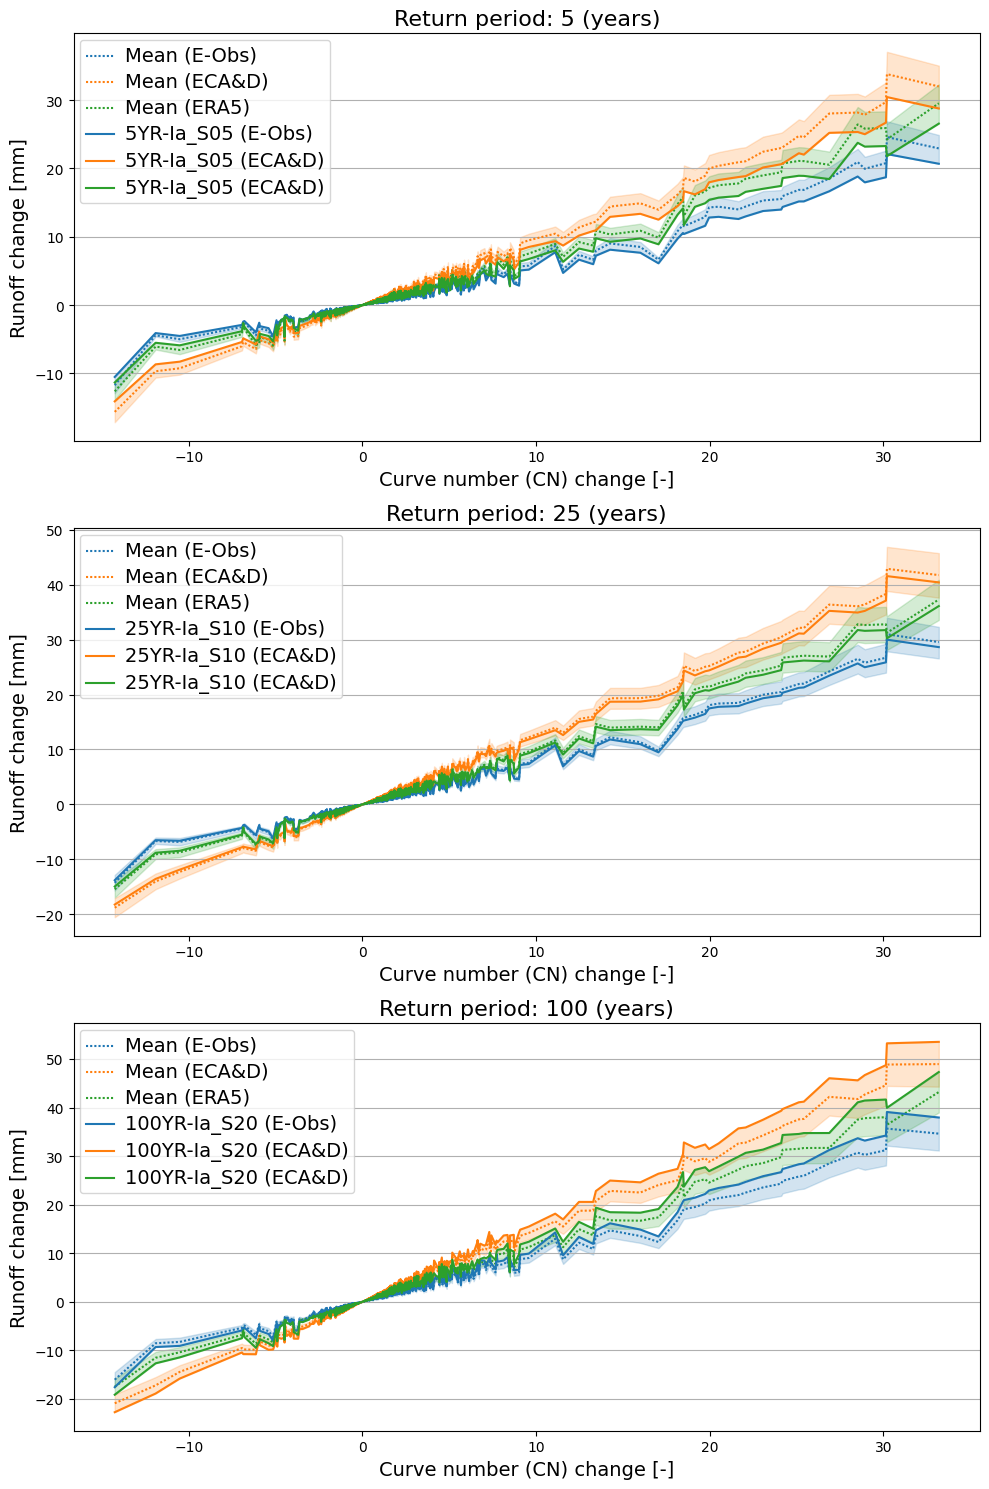

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume graph_df is your DataFrame containing the data

# Get unique RP years
rp_years = graph_df['RP_yr'].unique()

# Define the number of rows and columns based on the number of unique RP years
num_rows = len(rp_years)
num_cols = 1  # We're plotting one column

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows), sharex=False)
Ia_S_factors = [0.05, 0.1, 0.20]

# Iterate over unique RP years and create subplots
for i, rp_year, Ia_S_factor in zip([0,1,2],list(rp_years),Ia_S_factors):
    # Filter data for the current RP year
    df_rp_year = graph_df[graph_df['RP_yr'] == rp_year]

    # Plot lineplot for the current RP year
    sns.lineplot(data=df_rp_year, x='CN_change', y='Runoff_change', hue='Src', style='Src', dashes={'E_obs':(1,1), 'ECAD':(1,1), 'ERA':(1,1)}, estimator='mean', errorbar=("pi", 100), err_style='band',  ax=axes[i])
    # Plot lineplot for the current RP year
    sns.lineplot(data=df_rp_year[df_rp_year['Ia_S_factor'] == Ia_S_factor], x='CN_change', y='Runoff_change', hue='Src', ax=axes[i])

    # Set title for the subplot
    axes[i].set_title(f"Return period: {rp_year} (years)", fontsize=16)  # Set title font size
    # Set x-axis and y-axis labels
    axes[i].set_xlabel('Curve number (CN) change [-]', fontsize=14)  # Set x-axis label font size
    axes[i].set_ylabel('Runoff change [mm]', fontsize=14)     # Set y-axis label font size
    # Add horizontal grid lines
    axes[i].grid(axis='y')

# Add legend
legend = axes[0].legend(title='Legend Title')
legend.set_title('')  # Set legend title font size

# Set legend labels and font size
legend_labels = ['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '5YR-Ia_S05 (E-Obs)', '5YR-Ia_S05 (ECA&D)', '5YR-Ia_S05 (ECA&D)']
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)
    text.set_fontsize(14)  # Set legend label font size

# Add legend
legend = axes[1].legend(title='Legend Title')
legend.set_title('')  # Set legend title font size

# Set legend labels and font size
legend_labels = ['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '25YR-Ia_S10 (E-Obs)', '25YR-Ia_S10 (ECA&D)', '25YR-Ia_S10 (ECA&D)']
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)
    text.set_fontsize(14)  # Set legend label font size

# Add legend
legend = axes[2].legend(title='Legend Title')
legend.set_title('')  # Set legend title font size

# Set legend labels and font size
legend_labels = ['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '100YR-Ia_S20 (E-Obs)', '100YR-Ia_S20 (ECA&D)', '100YR-Ia_S20 (ECA&D)']
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)
    text.set_fontsize(14)  # Set legend label font size

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

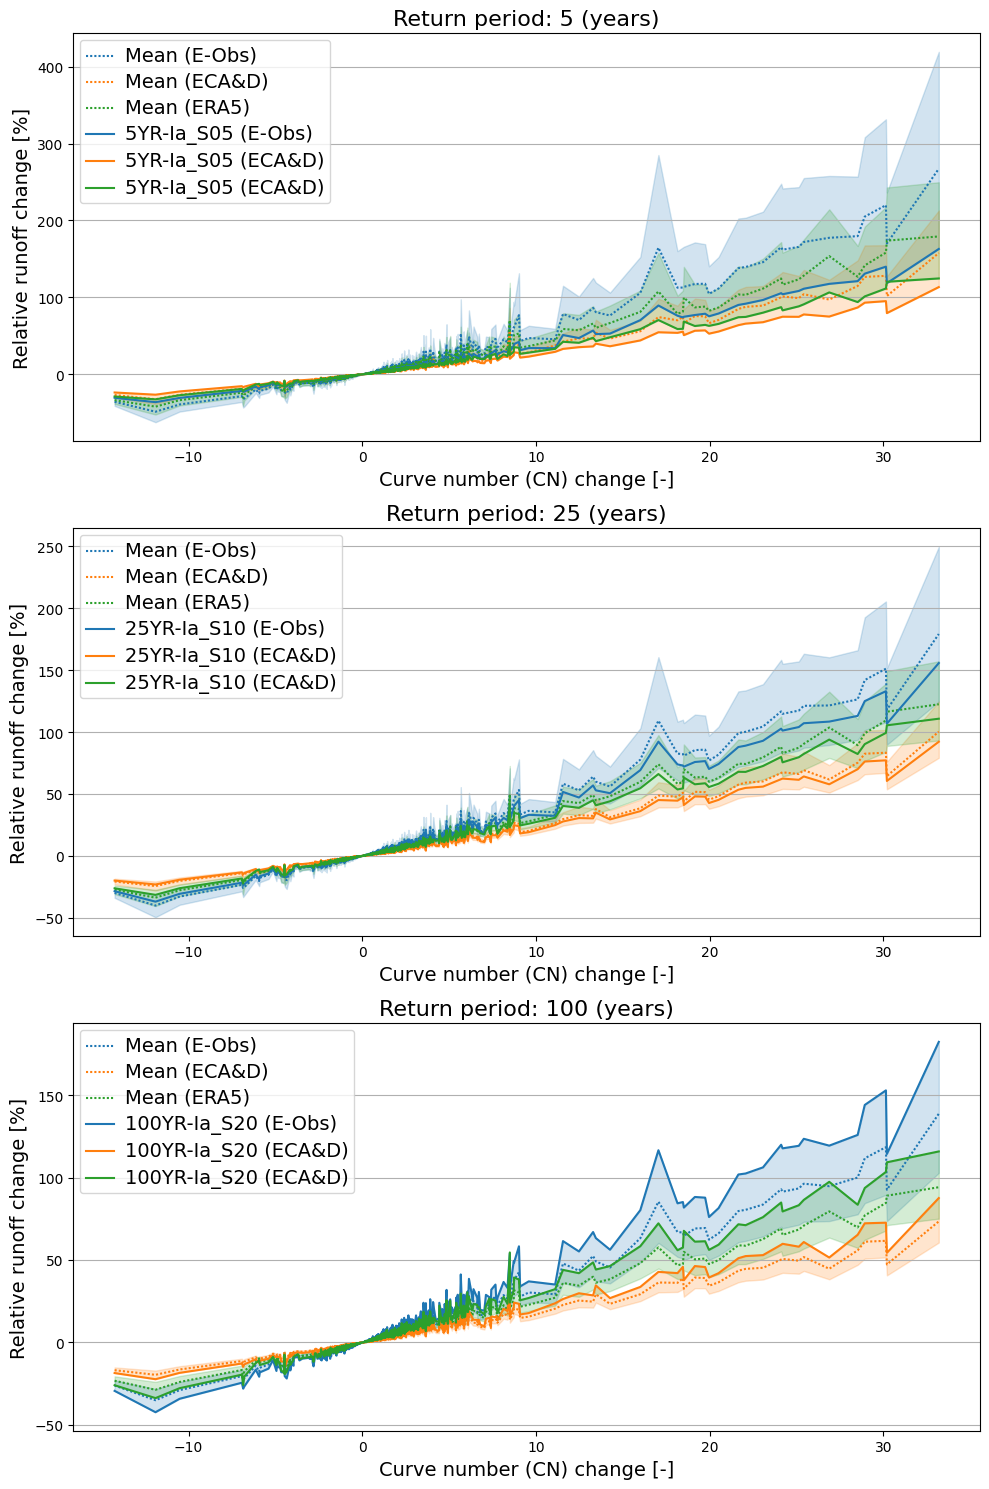

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume graph_df is your DataFrame containing the data

# Get unique RP years
rp_years = graph_df['RP_yr'].unique()

# Define the number of rows and columns based on the number of unique RP years
num_rows = len(rp_years)
num_cols = 1  # We're plotting one column

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows), sharex=False)
Ia_S_factors = [0.05, 0.1, 0.20]

# Iterate over unique RP years and create subplots
for i, rp_year, Ia_S_factor in zip([0,1,2],list(rp_years),Ia_S_factors):
    # Filter data for the current RP year
    df_rp_year = graph_df[graph_df['RP_yr'] == rp_year]

    # Plot lineplot for the current RP year
    sns.lineplot(data=df_rp_year, x='CN_change', y='Relative_runoff_change', hue='Src', style='Src', dashes={'E_obs':(1,1), 'ECAD':(1,1), 'ERA':(1,1)}, estimator='mean', errorbar=("pi", 100), err_style='band',  ax=axes[i])
    # Plot lineplot for the current RP year
    sns.lineplot(data=df_rp_year[df_rp_year['Ia_S_factor'] == Ia_S_factor], x='CN_change', y='Relative_runoff_change', hue='Src', ax=axes[i])

    # Set title for the subplot
    axes[i].set_title(f"Return period: {rp_year} (years)", fontsize=16)  # Set title font size
    # Set x-axis and y-axis labels
    axes[i].set_xlabel('Curve number (CN) change [-]', fontsize=14)  # Set x-axis label font size
    axes[i].set_ylabel('Relative runoff change [%]', fontsize=14)     # Set y-axis label font size
    # Add horizontal grid lines
    axes[i].grid(axis='y')

# Add legend
legend = axes[0].legend(title='Legend Title')
legend.set_title('')  # Set legend title font size

# Set legend labels and font size
legend_labels = ['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '5YR-Ia_S05 (E-Obs)', '5YR-Ia_S05 (ECA&D)', '5YR-Ia_S05 (ECA&D)']
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)
    text.set_fontsize(14)  # Set legend label font size

# Add legend
legend = axes[1].legend(title='Legend Title')
legend.set_title('')  # Set legend title font size

# Set legend labels and font size
legend_labels = ['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '25YR-Ia_S10 (E-Obs)', '25YR-Ia_S10 (ECA&D)', '25YR-Ia_S10 (ECA&D)']
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)
    text.set_fontsize(14)  # Set legend label font size

# Add legend
legend = axes[2].legend(title='Legend Title')
legend.set_title('')  # Set legend title font size

# Set legend labels and font size
legend_labels = ['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '100YR-Ia_S20 (E-Obs)', '100YR-Ia_S20 (ECA&D)', '100YR-Ia_S20 (ECA&D)']
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)
    text.set_fontsize(14)  # Set legend label font size

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Map results

In [ ]:
# Create a croquis of Iberian Peninsula
crs_IP = IP_allbasins_gdf.crs
mbz_names = IP_allbasins_gdf['namebasin'].unique()
croquis = gpd.GeoSeries(index=mbz_names , crs=crs_IP)
for mbz_name, mbz_gdf in IP_allbasins_gdf.groupby('namebasin'):
  mbz_boundary= mbz_gdf['geometry'].convex_hull.unary_union # Simplify boundaries
  croquis[mbz_name] = mbz_boundary
croquis

Duero           MULTIPOLYGON (((2760227.721 2171123.464, 27602...
Ebro            MULTIPOLYGON (((3230776.219 2223561.523, 32307...
Guadalquivir    MULTIPOLYGON (((2826408.965 1726944.683, 28237...
Jucar           MULTIPOLYGON (((3239252.840 1695500.859, 32390...
Tajo            MULTIPOLYGON (((2642834.205 1757698.503, 26428...
dtype: geometry

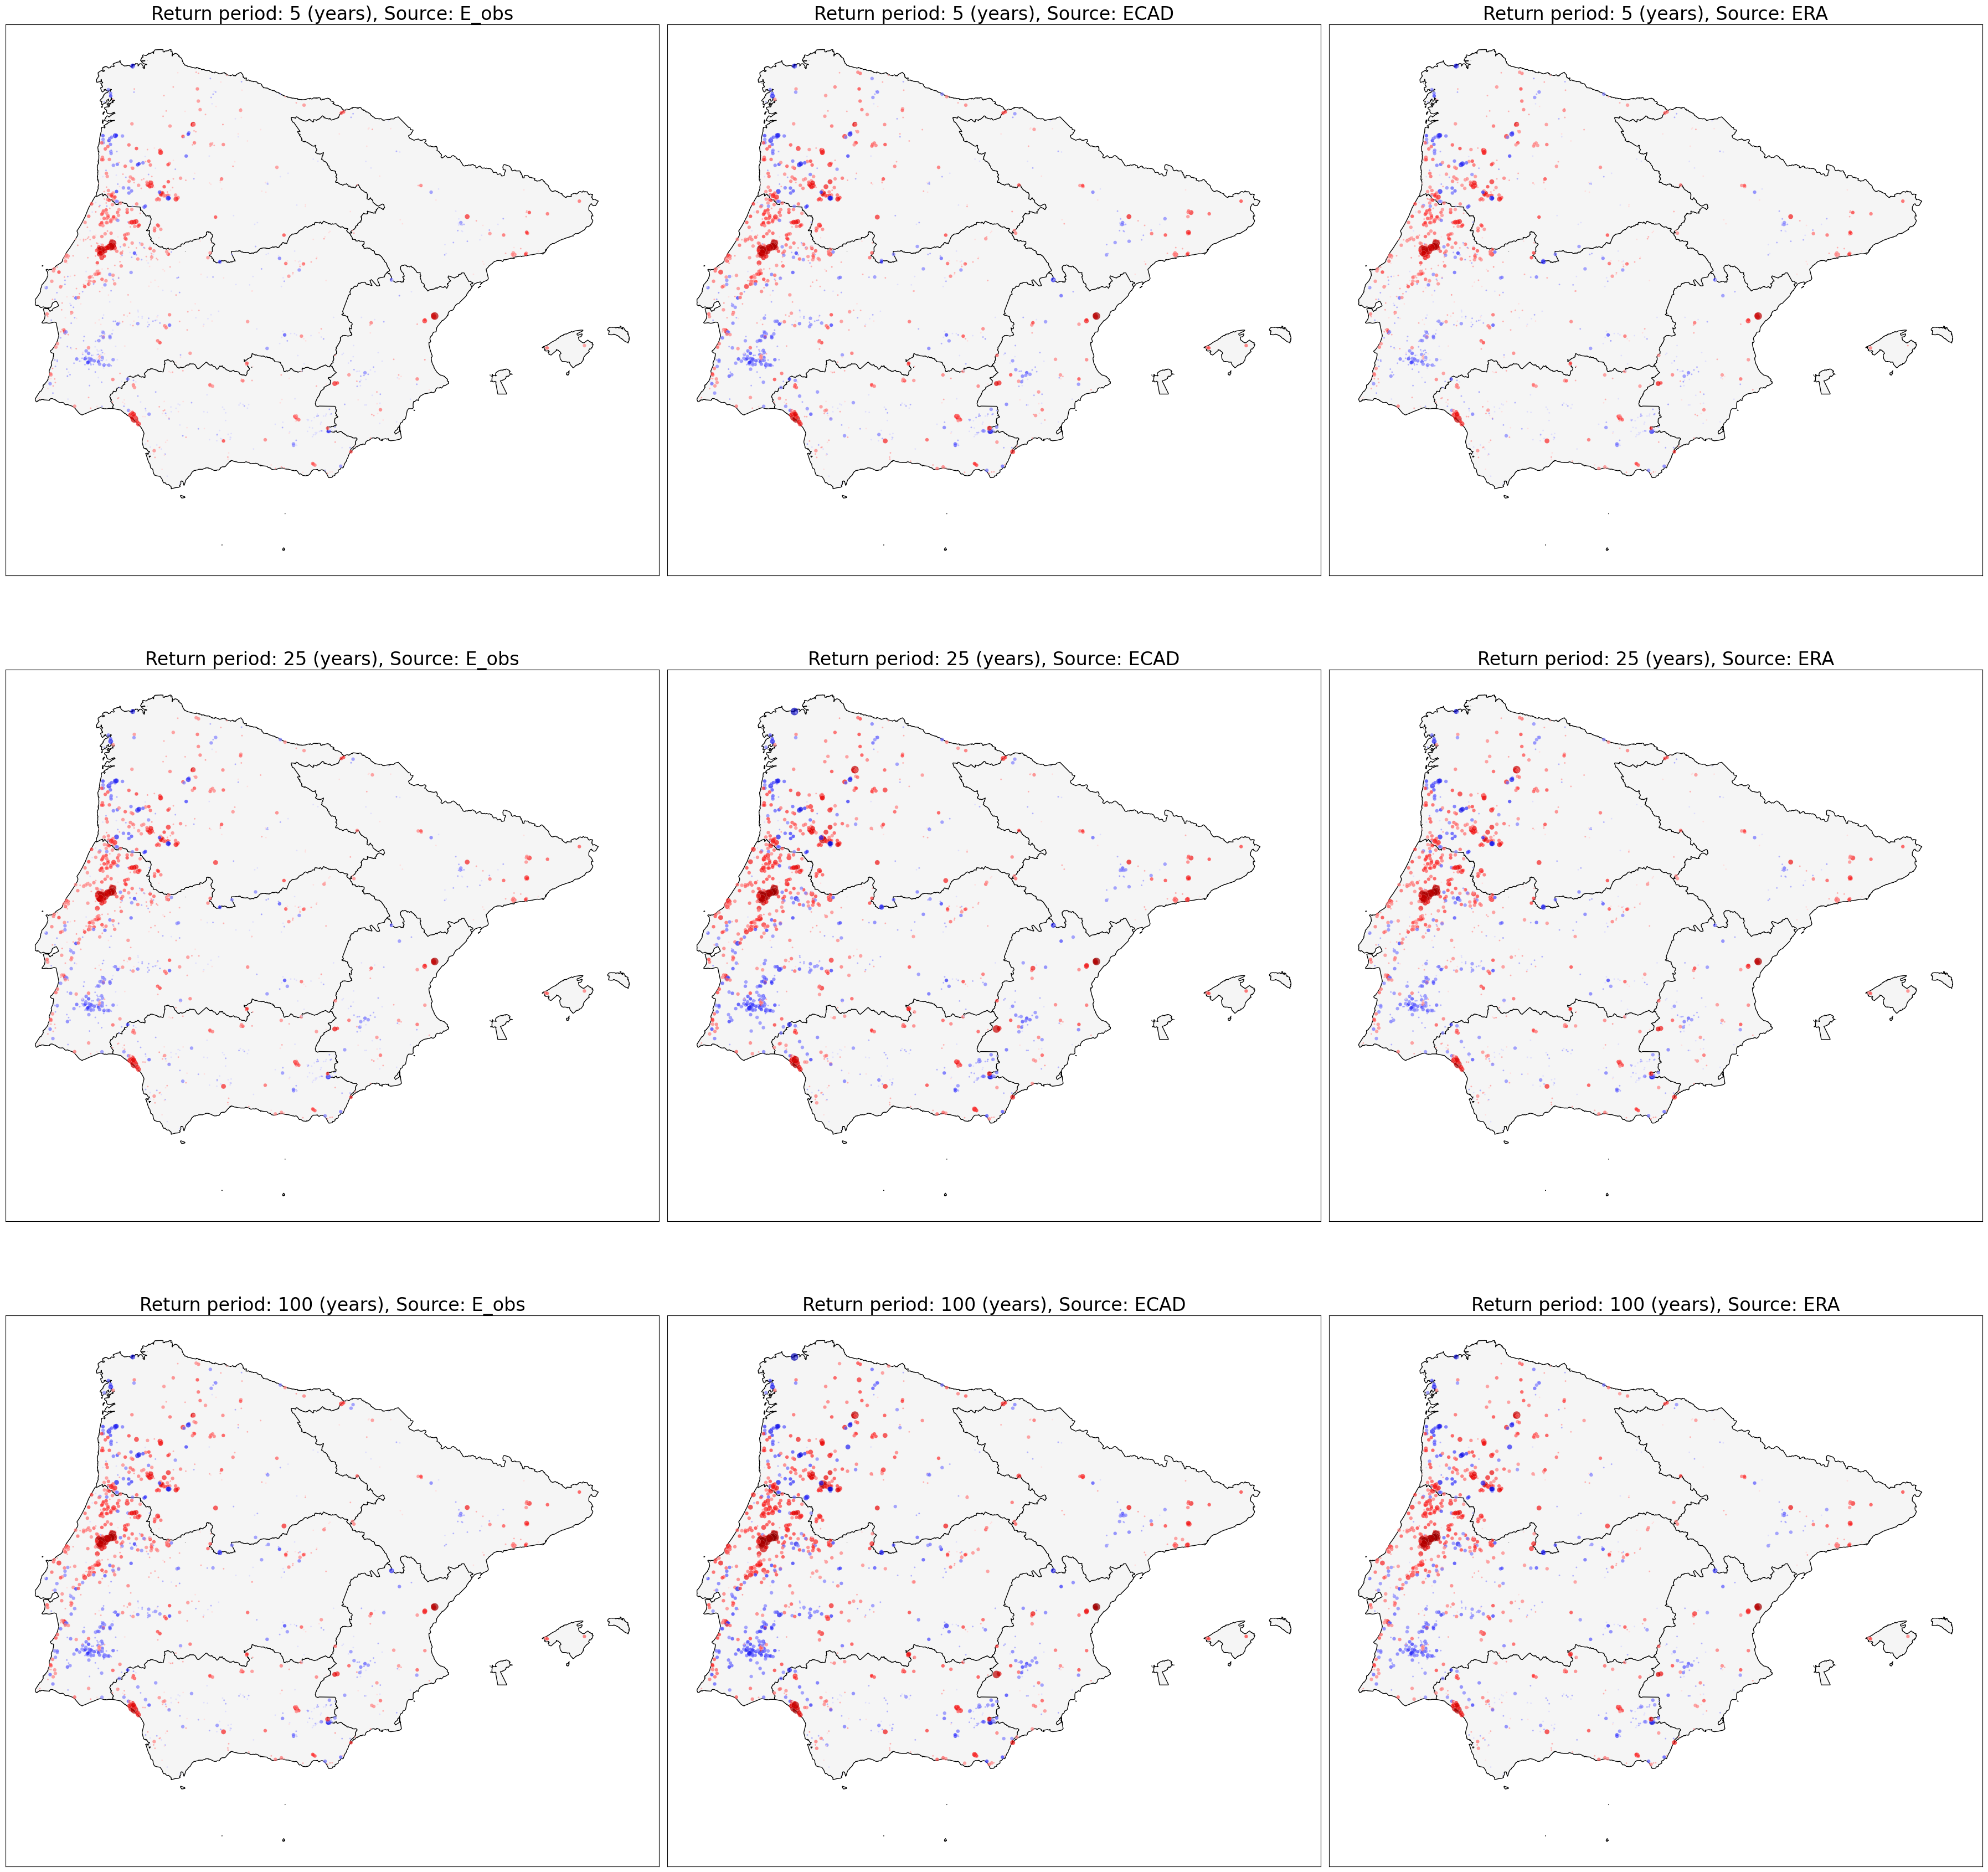

In [ ]:
colors = [(0.0, '#00004c'),
 (0.25, '#000092'),
 (0.4, '#0000db'),
 (0.475, '#3131ff'),
 (0.495, '#9999ff'),
 (0.5, '#fffdfd'),
 (0.505, '#ff9999'),
 (0.525, '#ff3131'),
 (0.6, '#e60000'),
 (0.75, '#b20000'),
 (1.0, '#800000')]



cmap = LinearSegmentedColormap.from_list('custom', colors)

# Add a color bar with correct normalization
norm = mcolors.Normalize(vmin=-60, vmax=60)  # Define the range for the colorbar

  # Define custom breaks and corresponding circle sizes
size_mapping = {
    (0, 1): 1,     # Circle size for values between 0 and 1 mm
    (1, 5): 10,   # Circle size f
    (5, 20): 20,   # Circle size
    (20, 100): 50,  # Circle size
    }


# Assume graph_df is your DataFrame containing the data
# Assume IP_basins_gdf is your GeoDataFrame containing the basin geometries

# Get unique RP years and sources
rp_years = graph_df['RP_yr'].unique()
Srcs = ['E_obs', 'ECAD', 'ERA']

# Define the number of rows and columns based on the number of unique RP years and sources
num_rows = len(rp_years)
num_cols = len(Srcs)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12*num_cols, 12*num_rows), sharex=True, sharey=True)
Ia_S_factors = [0.05, 0.1, 0.20]
# Iterate over unique RP years and create subplots
for i, rp_year, Ia_S_factors in zip([0,1,2],list(rp_years),Ia_S_factors):
    for j, src in enumerate(Srcs):
        # Filter data for the current RP year and source
        bdf = graph_df[(graph_df['RP_yr'] == rp_year) & (graph_df['Src'] == src) & (graph_df['Ia_S_factor'] == Ia_S_factor)]
        bdf.loc[:,'Abs_runoff_change'] = None
        bdf.loc[:,'Abs_runoff_change'] = bdf.loc[:,'Runoff_change'].abs()
        bdf = bdf.loc[bdf['Abs_runoff_change'] > 0, :]
        bdf['size_mapped'] = bdf['Abs_runoff_change'].apply(lambda x: next((size for (start, end), size in size_mapping.items() if start < x <= end), None))
        # Merge with basin geometries
        merged_df = bdf.merge(IP_basins_gdf[['Basin_ID', 'geometry']], on='Basin_ID', how='left')
        gdf = gpd.GeoDataFrame(merged_df)
        gdf = gdf.set_geometry('geometry')
        # Extract x and y coordinates from the 'geometry' column
        gdf['X_Centroid'] = gdf.centroid.geometry.x
        gdf['Y_Centroid'] = gdf.centroid.geometry.y
        croquis.plot(ax=axes[i, j], color='whitesmoke', edgecolor='black', zorder = 1)




        # Plot the scatterplot
        sns.scatterplot(data=gdf, x='X_Centroid', y='Y_Centroid', hue='Runoff_change', hue_norm=(-60, 60), size='size_mapped', sizes=(5, 100), palette=cmap, alpha=0.7, ax=axes[i, j])

        # Set title for the subplot
        axes[i, j].set_title(f"Return period: {rp_year} (years), Source: {src}", fontsize=24)
        # Set x-axis and y-axis labels
                # Hide axis ticks
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
        axes[i, j].get_legend().set_visible(False)

# Add legend
#legend = axes[0, 0].legend(title='Legend Title')
#legend.set_title('')
#legend.set_labels(['Mean (E-Obs)', 'Mean (ECA&D)', 'Mean (ERA5)', '5YR-Ia_S05 (E-Obs)', '5YR-Ia_S05 (ECA&D)', '5YR-Ia_S05 (ECA&D)'])
# Add a color bar
####cbar = fig.colorbar(None, ax=axes.ravel().tolist(), norm=norm, cmap=cmap, orientation='horizontal')
#cbar.ax.tick_params(labelsize=14)
#cbar.set_label('Runoff change [mm]', fontsize=16)
# Add legend with offset
handles, labels = axes[0, 0].get_legend_handles_labels()
labels = ['Absolute runoff change in a basin',
          '< 1 mm',
          '1 mm - 5 mm',
          '5 mm - 10 mm',
          '10 mm - 20 mm',
          '> 20 mm']
handles = handles[6:]
####fig.legend(handles, labels, bbox_to_anchor=(0.32, 0.32), loc='upper right')
#cbar.set_label('Runoff change [mm]', fontsize=14)


# Adjust layout
plt.tight_layout()
# Show plot
plt.show()


### Save results

In [ ]:
graph_df.to_file("/content/drive/MyDrive/Iberia_project/03_Results/IP_Selected_basins.gpkg", driver="GPKG"))